In [1]:
#Importing libraries                                                                                                                                import pandas as pd
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import netCDF4
import pandas as pd
import datetime
import scipy
import math
import matplotlib
import matplotlib.image as mpimg
from scipy import interpolate
import matplotlib.dates as mdates
from scipy.stats import *
import locale
import time
locale.getlocale()
# locale.setlocale(locale.LC_TIME,'en_US.)
locale.setlocale(locale.LC_TIME,'en_US.utf8')
locale.setlocale(locale.LC_ALL, 'en_US.utf8')
print(time.strftime("%d-%b-%Y"))


20-Jun-2022


In [2]:
#functions
def Language(g):
    global tunits,labeltM1,labelTS1,tlabel,Name
    if g=='RU':
        tunits='скорость верта м/с'
        labeltM1='WRF'
        labelTS1='наблюдение'  
        tlabel='Время суток'
        Name='NameRU'
        #locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')
    elif g=='EN':
        tunits='Wind speed m\s' 
        labeltM1='WRF Data sfc'
        labelTS1='Observation'     
        tlabel='Hour'
        Name='Name'
        locale.setlocale(locale.LC_TIME,'en_US.utf8')
def GeneratingListOfVariables(file_nc):
    nc = netCDF4.Dataset(file_nc,'r+')
    #print(nc.variables.items())
    times = nc.variables['time']
    #print(times)
    jd = netCDF4.num2date(times[:],times.units)
    nc.close
    variables=list(nc.variables.keys())[3::]
    return nc.variables,variables
def Graphercore(i,Variable,vari):
            lat=np.array(Variable['lat'])
            lon=np.array(Variable['lon'])
            Coord2= np.argmin(np.abs(lon - LOND[i]))
            Coord1= np.argmin(np.abs(lat - LATD[i]))
            print(lat[Coord1],lon[Coord2],'Lee coordinates')
            Var=np.array(Variable[vari])
            Var=Variable[vari][:,Coord1,Coord2]
            #date=Variable['time'].units.replace('minutes since ','')
            jd=pd.date_range(date,periods=len(Variable['time']),freq='H',name='Date')
            hs = pd.Series(Var,name=vari,index=jd) 
            return hs

In [3]:
LANG='RU'
Language(LANG)

In [67]:
date='2016-05-09 19:00';Date1='2016-05-10';Date2='2016-05-12';Date='20160501';Date3='2016-05-12 22:00'
date='2016-06-26 19:00';Date1='2016-06-27';Date2='2016-06-29';Date='20160627';Date3='2016-06-29 22:00'
date='2017-07-27 19:00';Date1='2017-07-28';Date2='2017-07-30';Date='20170728';Date3='2017-07-30 22:00'
# date='2018-07-12 19:00';Date1='2018-07-13';Date2='2018-07-15';Date='20180713';Date3='2018-07-15 22:00'
# date='2019-08-25 19:00';Date1='2019-08-26';Date2='2019-08-28';Date='20190826';Date3='2019-08-28 21:00'
# date='2020-02-10 19:00';Date1='2020-02-11';Date2='2020-02-13';Date='20200210';Date3='2020-02-13 21:00'
# date='2018-08-24 19:00';Date1='2018-08-25';Date2='2018-08-27';Date='20180825';Date3='2018-08-27 22:00'
ymin=0
ymax=15
locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')
Stations=[21206600,21206920,21206960,21185090,21195170,23035030,26145090]#the ones used to validate 
Stations=[21255160,21185090,21115180,21195170,23035030]#The ones used for analysis
# Stations=[21215180,21206920,21206990,21195170]
Stations=[21206920, 21195170,21206930]

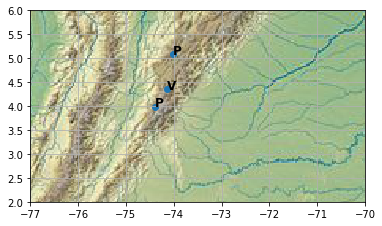

In [68]:
LATD=[]
LOND=[]
ALTD=[]
NAME=[]
Stationss=Stations
for i in range(len(Stationss)):
    i
    COD=Stationss[i]
    St=pd.read_csv('/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/Tesis/DATA/DataProcessing/Stations.csv')#Opening file with coordinates of Stations
    NAME.append(str.title(St[St['Station']==COD]['Name'].values[0]))
    LATD.append(round(St.latitud[St['Station']==COD].values[0],2))
    LOND.append(round(-St[St['Station']==COD]['longitud'].values[0],2))
    ALTD.append(St[St['Station']==COD]['altitud'].values[0])
ST=pd.DataFrame({'Name':NAME,'Longitude':LOND,'Latitude':LATD,'Altitude':ALTD},index=Stationss)
# F = [chr(ord('a') + x).upper() for x in ST.index]
ST.to_csv('StationsERAValidation.csv')
fig,ax=plt.subplots()
#ax.imshow(mpimg.imread('/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/Tesis/DATA/ERA5vsDATA/Colombia_Topography_2.png'),extent=(-80,-68,2,14))
IMTIF='Colombia_relief_location_map_modified'
ax.imshow(mpimg.imread('/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/DATA/WRFValidation/Colombia_relief_location_map.jpg'),extent=(-85.12,-66.44,-4.6,16.6))
plt.ylim([2,6])
plt.xlim([-77,-70])
plt.grid()
#LONN=[str(-x)+' W' for x in LON]
#ax.set_xticklabels(LONN)
for i, txt in enumerate(NAME):
    ax.annotate(str(txt)[0], (LOND[i], LATD[i]),color='black',weight='bold',fontsize=12)
ax.scatter(LOND,LATD,label='Data Stations')
# ax.scatter(LOND[0],LATD[0],label='Data Stations')#Just for onem station
# ax.scatter(LON,LAT,label='ERA 5')
# ax=fig.gca()
# plt.legend()
plt.show()


In [69]:
# ST['NameRU']=['Асиенда Пахоналес','Натайма','Асиенда Манила','Пакило','База Паланкеро',]
ST

,Name,Longitude,Latitude,Altitude
21206920,Villa Teresa,-74.15,4.35,3624
21195170,Paquilo,-74.40,3.99,2957
21206930,Paramo Guerrero,-74.02,5.09,3257


In [64]:
def Plotting(i):
    Language(LANG)
    ###############################
    #Uploading station data
    ###############################
    Path='/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/DATA/DATAfromIdeam/RADICADO_20229050002332/'
    Variable='VV_AUT_10@'
#     Variable='VVAG_CON@'
    StationT=str(Stations[i])
    Bs=pd.read_csv(Path+Variable+StationT+'.data',delimiter='|',parse_dates=True,header=0,names=['time','Station Data'],index_col='time')
    ###############################
    #Loading WRF data
    ###############################
    path='/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/Tesis/WRF/'
    path3='/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/DATA/WRFValidation/WindSpeed/'
    path3='/home/usuario/Desktop/imagesTobeerased/'
    Fil = ['/U10M.nc','/V10M.nc' ];vari=['u10m','v10m']
    fn=[ path+Date+i for i in Fil]
    ###############################
    UU,u=GeneratingListOfVariables(fn[0])
    VV,v=GeneratingListOfVariables(fn[1])                                        
    U=Graphercore(i,UU,vari[0])
    V=Graphercore(i,VV,vari[1])
    ###############################
    #Calculating magnitude of wind
    ###############################                                     
    B=np.sqrt(U**2+V**2)+6
    ###############################
    #Plots
    ################################
    fig, ax = plt.subplots()
    ax.set_ylim([ymin, ymax])
    B.plot(ylabel=tunits,ax=ax,label='WRF Data sfc')
    Bs[Bs.index.minute == 0][Date1:Date3].plot(ax=ax,xlim=[Date1,Date3],style='o',markersize=4)                      
    ax.set_xlabel(tlabel)
    ax.legend(loc='best',bbox_to_anchor=(1., 1.12))
#     ax.get_legend().remove()
    string=Date+'Vel'+ST.loc[Stations[i]]['Name']+'.png'
    plt.savefig(path3+string.replace(" ", ""), bbox_inches = "tight")
    ################################
    #Correlations
    ################################
    B.corr(Bs[Date1:Date2]['Station Data'])
    ST.loc[int(StationT),[r'$\rho$']]=round(B.corr(Bs[Date1:Date2]['Station Data']),2)
    ################################
    #Scatterplots
    ################################
    #print(ST.loc[Stations[i]])
    x=B[Date1:Date3]
    y=Bs[Bs.index.minute == 0][Date1:Date3].dropna()
    hh=x[x.index.isin(y.index)==True]
    fig2, ax2 = plt.subplots()
    ax2.set_xlabel(tunits);ax2.set_ylabel(tunits)
    ax2.scatter(hh,y,label=ST.loc[Stations[i]]['Name'])
    plt.legend()
    string=Date+'Vel'+'Scatter'+ST.loc[Stations[i]]['Name']+'.png'
    plt.savefig(path3+string.replace(" ", ""),bbox_inches='tight')
    plt.show()
    #################################
    # Mean Absolute Error MAE
    # Mean Bias     Error MBE
    #################################
    MAE=round(np.nansum(abs(hh.to_numpy()-y.to_numpy().T))/len(y),2)
    MBE=round(np.nansum(hh.to_numpy()-y.to_numpy().T)/len(y),2)
    ST.loc[int(StationT),['MAE']]=MAE
    ST.loc[int(StationT),['MBE']]=MBE
    rho=B.corr(Bs[Date1:Date2]['Station Data'])
    n=len(Bs[Date1:Date3])-2
    tSt=rho*math.sqrt(n-2)/math.sqrt(1-rho**2)
    pval = t.sf(np.abs(tSt), n)*2
    ST.loc[int(StationT),[r'$p_{val}$']]=str(pval)[0:4]+str(pval)[-4::]
    

4.3701 -74.15323076923077 Lee coordinates
4.3701 -74.15323076923077 Lee coordinates


IndexError: index 0 is out of bounds for axis 0 with size 0

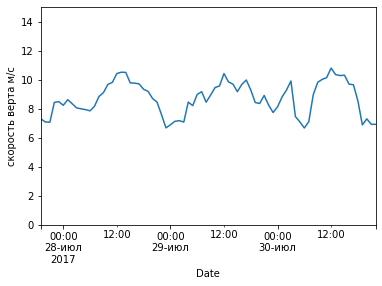

In [65]:
for i in range(len(Stations)):
    Plotting(i)

In [ ]:
ST

4.0099 -74.37894983277593 Lee coordinates
4.0099 -74.37894983277593 Lee coordinates


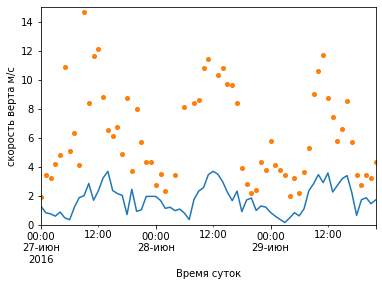

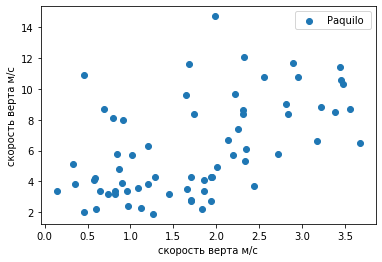

In [34]:
i=1
Language(LANG)
###############################
#Uploading station data
###############################
Path='/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/DATA/DATAfromIdeam/RADICADO_20229050002332/'
Variable='VV_AUT_10@'
Variable='VVMX_AUT_60@'
StationT=str(Stations[i])
Bs=pd.read_csv(Path+Variable+StationT+'.data',delimiter='|',parse_dates=True,header=0,names=['time','Station Data'],index_col='time')
Bs=Bs.resample('H').last()
###############################
#Loading WRF data
###############################
path='/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/Tesis/WRF/'
path3='/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/DATA/WRFValidation/WindSpeed/'
path3='/home/usuario/Desktop/imagesTobeerased/'
Fil = ['/U10M.nc','/V10M.nc' ];vari=['u10m','v10m']
fn=[ path+Date+i for i in Fil]
###############################
UU,u=GeneratingListOfVariables(fn[0])
VV,v=GeneratingListOfVariables(fn[1])                                        
U=Graphercore(i,UU,vari[0])
V=Graphercore(i,VV,vari[1])
###############################
#Calculating magnitude of wind
###############################                                     
B=np.sqrt(U**2+V**2)
##############################
#Plots
################################
fig, ax = plt.subplots()
ax.set_ylim([ymin, ymax])
B.plot(ylabel=tunits,ax=ax,label='WRF Data sfc')
Bs[Bs.index.minute == 0][Date1:Date3].plot(ax=ax,xlim=[Date1,Date3],style='o',markersize=4)                      
ax.set_xlabel(tlabel)
ax.legend(loc='best',bbox_to_anchor=(1., 1.12))
ax.get_legend().remove()
string=Date+'Vel'+ST.loc[Stations[i]]['Name']+'.png'
plt.savefig(path3+string.replace(" ", ""), bbox_inches = "tight")
################################
#Correlations
################################
B.corr(Bs[Date1:Date2]['Station Data'])
ST.loc[int(StationT),[r'$\rho$']]=round(B.corr(Bs[Date1:Date2]['Station Data']),2)
################################
#Scatterplots
################################
#print(ST.loc[Stations[i]])
x=B[Date1:Date3]
y=Bs[Bs.index.minute == 0][Date1:Date3].dropna()
hh=x[x.index.isin(y.index)==True]
fig2, ax2 = plt.subplots()
ax2.set_xlabel(tunits);ax2.set_ylabel(tunits)
ax2.scatter(hh,y,label=ST.loc[Stations[i]]['Name'])
plt.legend()
string=Date+'Vel'+'Scatter'+ST.loc[Stations[i]]['Name']+'.png'
plt.savefig(path3+string.replace(" ", ""),bbox_inches='tight')
plt.show()
#################################
# Mean Absolute Error MAE
# Mean Bias     Error MBE
#################################
MAE=round(np.nansum(abs(hh.to_numpy()-y.to_numpy().T))/len(y),2)
MBE=round(np.nansum(hh.to_numpy()-y.to_numpy().T)/len(y),2)
ST.loc[int(StationT),['MAE']]=MAE
ST.loc[int(StationT),['MBE']]=MBE
rho=B.corr(Bs[Date1:Date2]['Station Data'])
n=len(Bs[Date1:Date3])-2
tSt=rho*math.sqrt(n-2)/math.sqrt(1-rho**2)
pval = t.sf(np.abs(tSt), n)*2
ST.loc[int(StationT),[r'$p_{val}$']]=str(pval)[0:4]+str(pval)[-4::]


In [34]:
ST

,Name,Longitude,Latitude,Altitude,$\rho$,MAE,MBE,$p_{val}$
21255160,Hacienda Pajonales,-74.83,4.76,277,NaN,NaN,NaN,NaN
21185090,Nataima,-74.96,4.19,393,0.71,8.50,8.50,6.50e-65
21115180,Hacienda Manila,-75.08,3.13,600,0.30,7.23,7.23,8.58e-10
21195170,Paquilo,-74.40,3.99,2957,0.27,5.38,5.38,4.17e-08
23035030,Base Palanquero,-74.66,5.49,170,0.67,8.24,8.24,2.22e-54


In [27]:
Bs

,Station Data
time,
2010-01-06 00:00:00,0.0
2010-01-06 00:15:00,0.0
2010-01-06 00:30:00,0.0
2010-01-06 00:45:00,0.0
2010-01-06 01:00:00,0.0
...,...
2022-01-03 03:30:00,1.0
2022-01-03 03:40:00,0.5
2022-01-03 03:50:00,0.5
